# LSBI Example on the CMB Power Spectrum

## Linear Simulation-Based Infernence

Let us consider a $d$-dimensional dataset $D$ described by a model $\mathcal{M}$ with $n$ parameters $\theta = \{\theta_i\}$. We assume a Gaussian prior $\theta|\mathcal{M} \sim \mathcal{N}(\mu,\Sigma )$ with known mean and covariance. The likelihood $\mathcal{L}_\theta(D)$ for an arbitrary model is generally intractable, but here we approximate it as a homoscedastic Gaussian, where the mean $\mathcal{M}(\theta)$ depends on the parameters but the covariance $C$ does not, 
$$
	D|\theta,\mathcal{M} \sim \mathcal{N}\,\big(\mathcal{M}(\theta),C \big)
$$
Furthermore, we approximate the model linearly about a fiducial point $\theta_0$, such that $\mathcal{M}(\theta) \approx m + M\theta$, where $M \equiv \nabla_{\theta}\,\mathcal{M}\,\big\vert_{\theta_0}$ and $m \equiv \mathcal{M}(\theta_0) - M\theta_0$. Under these assumptions, the resulting likelihood is
$$
	D|\theta,\mathcal{M} \sim \mathcal{N}\,\big(m + M\theta,C \big)
$$
If we knew the likelihood hyperparameters $m$, $M$, and $C$, the posterior distribution could be found and would also be Gaussian
$$
	\theta| D,\mathcal{M}\sim \mathcal{N}\,\big(\mu_\text{P},\Sigma_\text{P}\big)
$$
where 
$$
	\Sigma_\text{P}^{-1} \equiv M^\text{T} C^{-1} M + \Sigma^{-1} ,	\quad\quad
	\mu_\text{P} \equiv \mu +  \Sigma_\text{P}	 M^\text{T} C^{-1} (D-m-M\mu) 		
$$
Similarly, the evidence would given by
$$
	D|\mathcal{M} \sim \mathcal{N}\,\big(m+M\mu, C+M\Sigma M^\text{T}\big).
$$
Nevertheless, $m$, $M$, and $C$ are unknown, so we must obtain their distributions before computing the posterior. One may obtain a numerical estimation of the likelihood through a simulator $\mathcal{S}_\mathcal{M}: \theta \mapsto D_\text{sim}$ by learning the probability density of the pairs $\{\theta^{(i)},D_\text{sim}^{(i)}\}$ for a sufficient number of simulator runs. Here, we follow a similar strategy, except that the assumption of linearity avoids the need for machine-learning tools.

We first draw $k$ parameter vectors $\{\theta^{(i)}\}$;  since we are estimating the likelihood, we may draw these from an arbitrary distribution that does not need to be the model prior $\pi(\theta)$. Then, for each $\theta^{(i)}$ the simulator is run to produce the corresponding data vector $D^{(i)}$. The function $\texttt{LSBI}$ takes these parameter-data pairs as input and computes the posterior distributions of the unknown hyperparameters $m$, $M$, and $C$.


In [194]:
import numpy as np
from scipy.stats import invwishart, matrix_normal, multivariate_normal
from lsbi.model import LinearModel

def LSBI(θ, D, C_0=0, ν_0=0, Θ_0 = 0,  *args, **kwargs):
    '''
    Implementation of Linear Simulation-Based Inference (LSBI).
    Here, n denotes the number of parameters, d is the dimension of the dataset, and k is the number of simulated parameter-data pairs

    Parameters
    ----------
    θ : array-like, dimensions (k,n)
        Vector of parameter samples for each simulator run
    D : array-like, dimensions (k,d)
        Vector of data samples for each simulator run
    shape : int or tuple
        Number of samples drawn from posterior distributions
        Can be made a tuple to get an array of custom dimensions
    C_0 : array-like, dimensions (d,d)
        Prior for the covariance matrix C; default = 0
    ν_0 : int
        Prior degrees of freedom; default = 0
    Θ_0 : array-like, dimensions (n,n)
        Prior for model matrix M (can be different to the prior covariance), defualt = 0

    Returns
    -------
    LinearModel object with updated likelihood hyper-parameters
    '''
    shape = kwargs.pop('shape', ())
    if isinstance(shape, int):
        shape = (shape,)
    k, n = θ.shape
    d = D.shape[1]
    
    θD = np.concatenate([θ, D], axis=1)
    mean = θD.mean(axis=0)
    θbar = mean[:n]
    Dbar = mean[n:]
    
    cov = np.cov(θD.T)
    Θ = cov[:n, :n]
    Δ = cov[n:, n:]
    Ψ = cov[n:, :n]
    ν = k - d - n - 2
    invΘ = np.linalg.inv(Θ + Θ_0/(k-1))
    
    C_ = invwishart(df=ν+ν_0, scale=((k-1)*(Δ-Ψ @ invΘ @ Ψ.T)+C_0)).rvs(shape)
    L1 = np.linalg.cholesky(C_/(k-1))
    L2 = np.linalg.cholesky(invΘ)
    L3 = np.linalg.cholesky(C_/(k+1))
    M_ = Ψ @ invΘ + np.einsum('...jk,...kl,ml->...jm', L1, np.random.randn(*shape, d, n), L2)
    m_ = (k/(k+1))*(Dbar - M_ @ θbar) + np.einsum('...jk,...k->...j', L3, np.random.randn(*shape, d))
    
    return LinearModel(m=m_, M=M_, C=C_, *args, **kwargs)

We have define the first- and second-order statistics
$$
	\bar{\theta} = \frac{1}{k}\sum^k_{i=1} \theta^{(i)}, \qquad \bar{D} = \frac{1}{k}\sum^k_{i=1} D^{(i)},
$$
and
\begin{align}
	\Theta 	&= \frac{1}{k-1}\sum^k_{i=1} (\theta^{(i)}-\bar{\theta})(\theta^{(i)}-\bar{\theta})^\text{T}, \\
    \Delta 	&= \frac{1}{k-1}\sum^k_{i=1} ( D^{(i)}-\bar{ D})( D^{(i)}-\bar{D})^\text{T}, \\
    \Psi 	&= \frac{1}{k-1}\sum^k_{i=1} ( D^{(i)}-\bar{D})(\theta^{(i)}-\bar{\theta})^\text{T},
\end{align}
Then, by expanding the joint likelihood,
\begin{align*}
	\log p(\{D_i\}|\{\theta_i\},m,M,C) 
		&\equiv \textstyle\sum^k_{i=1} \log p(D_i|\theta_i,m,M,C)								\\
		& = -\tfrac{k}{2}\log|2\pi C|
			-\tfrac{1}{2}\textstyle\sum^k_{i=1} ( D_i - m - M\theta_i)^\text{T} C^{-1}( D_i - m - M\theta_i) \\
		& = -\tfrac{k}{2}\log|2\pi C|
			-\tfrac{1}{2}\big[ m- (\bar D-M\bar\theta) \big]^\text{T} (C/k)^{-1}\big[ m- (\bar D-M\bar\theta)\big] 	\\
		&\qquad\qquad \textstyle 
			-\frac{k-1}{2} \text{tr}\,\big[ \Theta (M-\Psi\Theta^{-1})^\text{T} C^{-1}(M-\Psi\Theta^{-1})\big]
			- \frac{k-1}{2} \text{tr}\,\big((\Delta -  \Psi \Theta^{-1}\Psi^\text{T})C^{-1}\big).
\end{align*}
and choosing the following conjugate priors, we can infer a joint posterior for $m, M$ and $C$
\begin{align}
	& C  \sim \mathcal{W}^{-1}(C_0, \nu_0) &&  C|S,\nu  \sim \mathcal{W}^{-1}\Big((k-1)(\Delta - \Psi\Theta^{-1}\Psi^\text{T})+C_0, \ \nu+\nu_0\Big)\\
	& M|C \sim \mathcal{MN}(0,C, \Theta_0^{-1} ) &&  M|C,S \sim \mathcal{MN}\Big(\Psi(\tfrac{1}{k-1}\Theta_0+\Theta)^{-1},\tfrac{1}{k-1}C, (\tfrac{1}{k-1}\Theta_0+\Theta)^{-1}\Big) \\
	& m|M,C \sim \mathcal{N}(0,C) &&  m|M,C,S \sim \mathcal{N}\Big(\tfrac{k}{k+1}(D-M\bar\theta),C/(k+1) \Big) 
\end{align} 
we obtain the conditional distributions on $m$, $M$, and $C$,
\begin{align}
	m|M,C,S &\sim \mathcal{N}\big(\bar{D} - M\bar{\theta}, \tfrac{1}{k}C\big)\\
    M|C,S &\sim \mathcal{MN}\big(\Psi\Theta^{-1}, \tfrac{1}{k-1}C, \Theta^{-1}\big),\\
    C|S &\sim \mathcal{W}^{-1}\big((k-1)(\Delta - \Psi\Theta^{-1}\Psi^\text{T}),\nu\big),\\
    \nu &= k-d-n-2,
\end{align}
where $S = \{(\theta^{(i)},D^{(i)})\}$ are the simulated parameter-data pairs, $\mathcal{MN}(M,U,V)$ stands for the matrix normal distribution with mean $M$ and covariance $U\otimes V$, and $\mathcal{W}^{-1}(\Lambda,\nu)$ stands for the inverse Wishart distribution with scale matrix $\Lambda$ and $\nu$ degrees of freedom. Note that $\nu>d-1$, so there is a minimum number of simulations $k_\text{min} = n+2d+2$ required to yield well-defined distributions.

## The CMB Power Spectrum

The anisotropies in the CMB can be decomposed in terms of spherical harmonics
\begin{equation}
	T(\theta,\phi) = \sum_{\ell, m} a_{\ell,m}Y_{\ell,m}(\theta,\phi), \quad a_{\ell,m} \sim \mathcal{N}(0,C_\ell).
\end{equation}
Accounting for noise, $n_{\ell,m}\sim \mathcal{N}(0,N_\ell)$, the observed signal $\hat{a}_{\ell,m}$ has total variance $C_\ell+N_\ell$.
The CMB power spectrum is then defined as
\begin{equation}
	\mathcal{C}_\ell = \frac{1}{2\ell+1}\sum_{m=-\ell}^\ell |a_{\ell,m}|^2,
\end{equation}
which, being a sum of squares of normally distributed random variables, follows a $\chi^2$-distribution
\begin{equation}
	\frac{2\ell+1}{C_\ell+N_\ell}\mathcal{C_\ell}\ \sim\  \chi^2(2\ell+1).
\end{equation}

The Lambda-Cold-Dark-Matter ($\mathrm{\Lambda}\text{CDM}$) model, which describes a flat universe dominated by non-relativistic dark matter and a non-zero cosmological constant, is considered the standard model of contemporary cosmology. It provides an account of the structure and evolution of the early universe, and can describe the temperature anisotropies of the CMB with only six parameters:

- The Hubble constant $H_0$,
- The densities of baryonic matter $\Omega_\text{b}h^2$ and cold dark matter $\Omega_\text{c}h^2$, where $h = H_0/$100km s^-1^ Mpc^-1^,
- The reionisation optical depth $\tau$, describing how much the primary CMB anisotropies are scattered by the reionised medium at low redshifts.
- The amplitude $A_\text{s}$ and slope $n_\text{s}$ of the initial power spectrum of density perturbations.

 To generate the datasets, we use the emulator $\texttt{cmbemu}$, developed by H.T.J. Bevins, which produces a dataset of 300 $\mathcal{C}_\ell$ points for $\ell$ in the range $[2,2000]$. Run the cell below to train the neural network on the data provided in the '$\texttt{data}$' folder; this will generate a '$\texttt{results}$' folder with the output (takes about 20 min). Make sure that $\texttt{train_network = True}$.


In [195]:
%%script echo skipping

import numpy as np
from cmbemu.preprocess import process
from cmbemu.network import nn

train_network = False

data_dir = 'data/'
base_dir = 'results/'
l = np.linspace(2, 2000, 300)
num = 'full'

if train_network:
    process(num, l, base_dir=base_dir, data_location=data_dir)

    nn(batch_size=300, epochs=20, base_dir=base_dir, input_shape=7,  layer_sizes=[14,14,14,14], patience=5)

skipping


##### Optional:
Run the cell below to test the emulator against some test data. Make sure that $\texttt{test_network = True}$.

In [196]:
%%script echo skipping

import numpy as np
import matplotlib.pyplot as plt
from cmbemu.eval import evaluate

test_network = False


test_data = np.loadtxt(data_dir + 'test_data.txt')
test_labels = np.loadtxt(data_dir + 'test_labels.txt')

if test_network:

    predictor = evaluate(base_dir=base_dir)

    error = []
    for i in range(len(test_data)):
        error.append(np.abs(predictor(test_data[i])[0] - test_labels[i])/test_labels[i]*100)
    error = np.array(error)

    plt.plot(l, np.mean(error, axis=0))
    plt.xlabel(r'$C_\ell$')
    plt.xlabel('Error, %')
    plt.show()

skipping


The function $\texttt{CMB_simulator}$ reproduces the noisy power spectrum for a given set of $C_\ell$s (there is also compression factor, $\texttt{comp}$, which produces a dataset composed of every $\texttt{comp}$^th^ point in the original dataset (useful for speeding up calculations, but recommended to be kept as 1)

In [197]:
%%script echo skipping

import numpy as np
from scipy.stats import chi2
from cmbemu.eval import evaluate

predictor = evaluate(base_dir=base_dir)

def CMB_simulator(θ,comp):
    signal = predictor(θ)[0][::comp] * chi2.rvs(2 * l[::comp] + 1) / (2 * l[::comp] + 1)
    return signal


skipping


## The Simulations

We first define a sampling distribution for the CMB parameters $\theta_\text{CMB} = (\Omega_\text{b}h^2,\, \Omega_\text{c}h^2,\, \tau,\, \ln(10^{10}A_\text{s}),\, n_\text{s},\,H_0)$; we will take this to be the prior itself, which is given by
\begin{align}
\mu &= (2.22\times10^{-2},\, 0.120,\, 6.66\times10^{-2},\, 3.05,\, 0.964\times10^{-1},\, 67.3),\\
\Sigma &= \text{diag}(1.05\times10^{-3},\, 8.28\times10^{-3},\, 3.47\times10^{-2},\, 1.47\times10^{-1},\, 2.64\times10^{-2},\, 3.38).
\end{align}


In [198]:
%%script echo skipping

params = np.loadtxt(data_dir + 'train_data.txt')
μ = np.mean(params, axis=0)
Σ = np.eye(6)*np.std(params, axis=0) ** 2

skipping


We also define the ground truth, and the corresponding 'observed data'.

In [199]:
%%script echo skipping

θ_0 = LinearModel(mu=μ, Sigma=Σ).prior().rvs()

D_0 = np.array(CMB_simulator(θ_0, 1))

skipping


We will do this for $k=10^4$ simulations. The varable $\texttt{rounds}$ determines the number of sequential LSBI rounds.

In [200]:
%%script echo skipping

from tqdm import tqdm

rounds = 20

k = 10000

θ = LinearModel(mu=μ, Sigma=Σ).prior().rvs(size=k)

# simulate data points
D = []
print(f'Round 1 of {rounds}.')
print('Running %s simulations...' % k)
for i in tqdm(range(k)):
    signal = CMB_simulator(θ[i, :], 1)
    D.append(np.array(signal))
D = np.array(D)

skipping


Next, we perform LSBI on our parameter data pairs; we will generate $N_s=$100 samples of the hyperparameters $m$, $M$ and $C$. Furthermore, for each instance we will draw $N_p=$1000 posterior samples, for a total of 10^5^ points for plotting.

In [201]:
%%script echo skipping

import timeit

N_s = 100
N_p = 100000//N_s

samples_0 = LinearModel(mu=μ, Sigma=Σ).prior().rvs(size=N_s*N_p)

print(f'Estimating posterior...')
start = timeit.default_timer()

model = LSBI(θ,D,shape=N_s, mu=μ, Sigma=Σ)
samples_1 = model.posterior(D_0).rvs(size=N_p).reshape(N_s*N_p,6)

time = timeit.default_timer() - start
print(f'Time elapsed: {round(time,2)} seconds.')

skipping


In [202]:
%%script echo skipping

samples = [samples_0, samples_1]

D_KL = [np.mean(model.dkl(D_0))]

for r in range(rounds-1):
    μ = model.posterior(D_0).mean[0]
    Σ = model.posterior(D_0).cov[0]

    θ = model.posterior(D_0).rvs(size=k//N_s).reshape(k,6)

    # simulate data points
    D = []
    print(' ')
    print(f'Round {r+2} of {rounds}.')
    print(f'Running {k} simulations...')
    for i in tqdm(range(k)):
        signal = CMB_simulator(θ[i, :], 1)
        D.append(np.array(signal))
    D = np.array(D)
    
    print(f'Estimating posterior...')
    start = timeit.default_timer()
    
    model = LSBI(θ,D,shape=N_s, mu=μ, Sigma=Σ)
    samples.append(model.posterior(D_0).rvs(size=N_p).reshape(N_s*N_p,6))
    
    time = timeit.default_timer() - start
    print(f'Time elapsed: {round(time,2)} seconds.')
    
    
    
    
    D_KL.append(np.mean(model.dkl(D_0)))


skipping


## Plotting

In [203]:
%%script echo skipping

import matplotlib.pyplot as plt
from getdist import plots, MCSamples

names = ["θ%s"%i for i in range(6)]
labels = [r'\Omega_b',r'\Omega_c',r'\tau',r'\ln(10^{10} A_s)',r'N_s',r'H_0']
markers= {'θ0':θ_0[0],'θ1':θ_0[1],'θ2':θ_0[2],'θ3':θ_0[3],'θ4':θ_0[4],'θ5':θ_0[5]}

MCsamples = []
for r in range(rounds+1):
    if not r:
        MCsamples.append(MCSamples(samples=samples[r], names=names, labels=labels, label='Prior'))
    else:
        MCsamples.append(MCSamples(samples=samples[r], names=names, labels=labels, label='Round %s'%r))

g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([MCsamples[i] for i in range(0,len(MCsamples),2)], markers=markers, filled=True, 
                legend_loc='upper right', contour_colors=['gray','#006FED', '#E03424', '#009966',  '#000866',  '#336600', 'm', 'r'])
plt.suptitle('Posterior estimate for CMBEMU, %s simulations per round'%k)
plt.savefig('figures/cmbemu_sequential_2.pdf')
plt.show()

skipping


In [204]:
%%script echo skipping

plt.plot(D_KL)
plt.title(r'Convergence of the $D_KL$')
plt.show()

skipping


## Again, with CosmoPowerJAX

In [205]:
import numpy as np
from cosmopower_jax.cosmopower_jax import CosmoPowerJAX

emulator = CosmoPowerJAX(probe='cmb_tt')

In [206]:
import numpy as np
from scipy.stats import chi2

l = np.arange(2, 2509)

class CMB(object):
    def __init__(self, Cl):
        self.Cl = Cl

    def rvs(self, shape=()):
        shape = tuple(np.atleast_1d(shape))
        return chi2(2*l+1).rvs(shape + self.Cl.shape)*self.Cl/(2*l+1)

    def logpdf(self, x):
        return (chi2(2*l+1).logpdf((2*l+1)*x/self.Cl)  + np.log(2*l+1)-np.log(self.Cl)).sum(axis=-1)

In [207]:
paramnames = [('Ωbh2', r'\Omega_b h^2'), ('Ωch2', r'\Omega_c h^2'), ('h', 'h'), ('τ', r'\tau'), ('ns', r'n_s'), ('lnA', r'\ln(10^{10}A_s)')]
params = ['Ωbh2', 'Ωch2', 'h', 'τ', 'ns', 'lnA']

θmin, θmax = np.array([[0.01865, 0.02625], [0.05, 0.255], [0.64, 0.82], [0.04, 0.12], [0.84, 1.1], [1.61, 3.91]]).T

μ = (θmin + θmax)/2
Σ = (θmax - θmin)**2

In [208]:
import timeit

rounds = 4

k = 10000

θ = np.random.uniform(θmin, θmax, size=(k, 6))

print(f'Round 1 of {rounds}.')
print('Running %s simulations...' % k)
start = timeit.default_timer()
Cl = emulator.predict(θ)
D = CMB(Cl).rvs()
time = timeit.default_timer() - start
print(f'Time elapsed: {round(time,2)} seconds.')

θ_0 = θ[0]
D_0 = D[0]

Round 1 of 3.
Running 10000 simulations...
Time elapsed: 1.38 seconds.


In [209]:
N_s = 100
N_p = 100000//N_s

samples_0 = LinearModel(μ=μ, Σ=Σ).prior().rvs(size=N_s*N_p)

print(f'Estimating posterior...')
start = timeit.default_timer()

model = LSBI(θ,D,shape=N_s, μ=μ, Σ=Σ)
samples_1 = model.posterior(D_0).rvs(size=N_p).reshape(N_s*N_p,6)

time = timeit.default_timer() - start
print(f'Time elapsed: {round(time,2)} seconds.')



Estimating posterior...
Time elapsed: 4.94 seconds.


In [210]:
samples = [samples_0, samples_1]

D_KL = [np.mean(model.dkl(D_0))]

for r in range(rounds-1):
    #μ = model.posterior(D_0).mean[0]
    #Σ = model.posterior(D_0).cov[0]

    θ = model.posterior(D_0).rvs(size=k//N_s).reshape(k,6)
    
    print(' ')
    print(f'Round {r+2} of {rounds}.')
    
    print(f'Running {k} simulations...')
    start = timeit.default_timer()
    
    Cl = emulator.predict(θ)
    D = CMB(Cl).rvs()
    
    time = timeit.default_timer() - start
    print(f'Time elapsed: {round(time,2)} seconds.')
    
    
    print(f'Estimating posterior...')
    start = timeit.default_timer()
    
    model = LSBI(θ,D,shape=N_s, μ=μ, Σ=Σ)
    samples.append(model.posterior(D_0).rvs(size=N_p).reshape(N_s*N_p,6))
    
    time = timeit.default_timer() - start
    print(f'Time elapsed: {round(time,2)} seconds.')
    
    
    

 
Round 2 of 3.
Running 10000 simulations...
Time elapsed: 1.21 seconds.
Estimating posterior...
Time elapsed: 5.22 seconds.
 
Round 3 of 3.
Running 10000 simulations...
Time elapsed: 1.21 seconds.
Estimating posterior...
Time elapsed: 5.35 seconds.


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


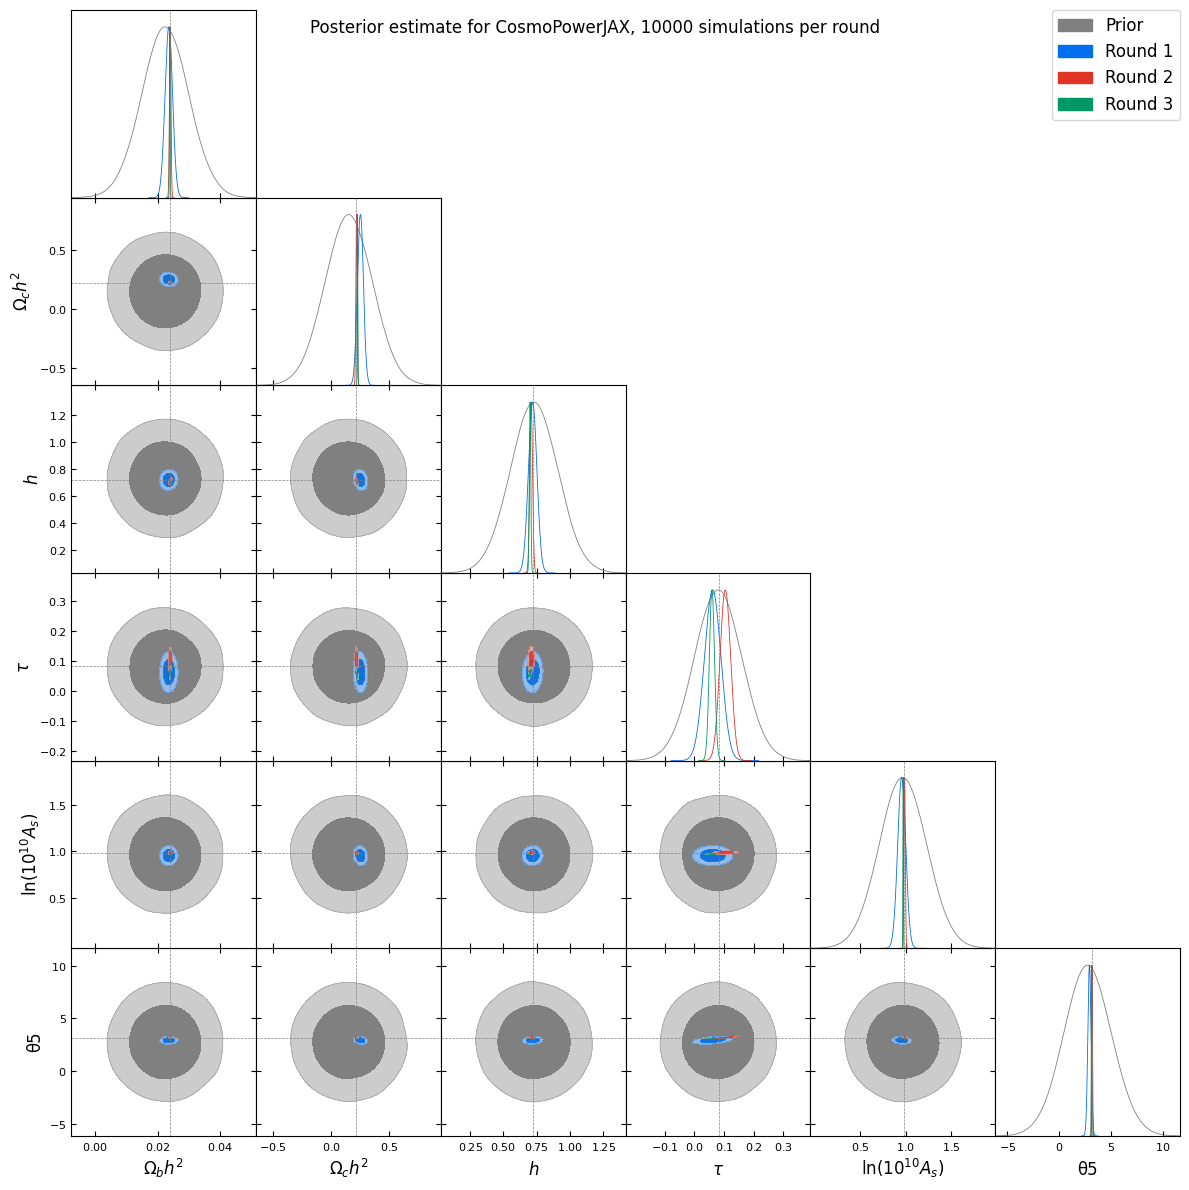

In [211]:
import matplotlib.pyplot as plt
from getdist import plots, MCSamples

names = ["θ%s"%i for i in range(6)]
labels = [r'\Omega_b',r'\Omega_c',r'\tau',r'\ln(10^{10} A_s)',r'N_s',r'H_0']
markers= {'θ0':θ_0[0],'θ1':θ_0[1],'θ2':θ_0[2],'θ3':θ_0[3],'θ4':θ_0[4],'θ5':θ_0[5]}

MCsamples = []
for r in range(rounds+1):
    if not r:
        MCsamples.append(MCSamples(samples=samples[r], names=names, labels=labels, label='Prior'))
    else:
        MCsamples.append(MCSamples(samples=samples[r], names=names, labels=labels, label='Round %s'%r))

g = plots.get_subplot_plotter()
g.settings.legend_fontsize = 15
g.settings.axes_labelsize = 15
g.triangle_plot([MCsamples[i] for i in range(len(MCsamples))], markers=markers, filled=True, 
                legend_loc='upper right', contour_colors=['gray','#006FED', '#E03424', '#009966',  '#000866',  '#336600', 'm', 'r'])
plt.suptitle('Posterior estimate for CosmoPowerJAX, %s simulations per round'%k)
plt.show()